# Udacity Self Driving Car Nanodegree
## Vehicle Detection Project
### Brian Fischer

## Table of Contents
[Introduction](#introduction)

1. [Data Exploration](#data)
2. [Feature Extraction](#features)
3. [Train a Classifier](#train)
4. [Sliding Window Algorithm](#sliding_window)
5. [Video Pipeline](#pipeline)
6. [Heat Map Algorithm](#heat_map)
7. [Bounding Box Algorithm](#calculations)
8. [Run Pipeline on Project Video](#project_video)

## Introduction <a name="introduction"></a>

The goals / steps of this project are the following:

1. **Data Exploration**<br>
Review the available data set contents and quality<br>
<br>
1. **Feature Extraction**<br>
Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images<br>
<br>
2. **Train a Classifier**<br>
From SVM, use the Linear Support Vector Classification (SVC)<br>
<br>
3. **Sliding Window Algorithm**<br>
Implement a sliding-window technique and use your trained classifier to search for vehicles in images.<br>
<br>
4. **Test Sliding Window Algorithm**<br>
Test on static images and tweak the algorithm parameters
<br>
<br>
5. **Heat Map Algorithm**<br>
Create a heat map of recurring detections in the pipeline, reject outliers and follow detected vehicles.
Threshold and label the heatmap.
<br>
<br>
6. **Bounding Box Algorithm**<br>
Estimate a bounding box for vehicles detected.  Needs to account for overlap and multiple vehicles
<br>
<br>
7. **Implement a Video Pipeline**<br>
Allow the algorithm to run frame by frame
<br>
<br>
8. **Run Pipeline on Project Video**<br>
Run your pipeline on the project videos and 
Optional: Output a visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position!

## Imports <a name="imports"></a>
All of the required project imports are listed at the top of this notebook

In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.externals import joblib

from scipy.ndimage.measurements import label

%matplotlib inline

## Training Data

In [2]:
vehicles     = glob.glob('data/vehicles/**/*.png', recursive=True)
non_vehicles = glob.glob('data/non-vehicles/**/*.png', recursive=True)
print("Vehicle Images:\t\t", len(vehicles))
print('Non-vehicle Images:\t', len(non_vehicles))

Vehicle Images:		 8792
Non-vehicle Images:	 8968


## 1. Data Exploration <a name="data"></a>

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

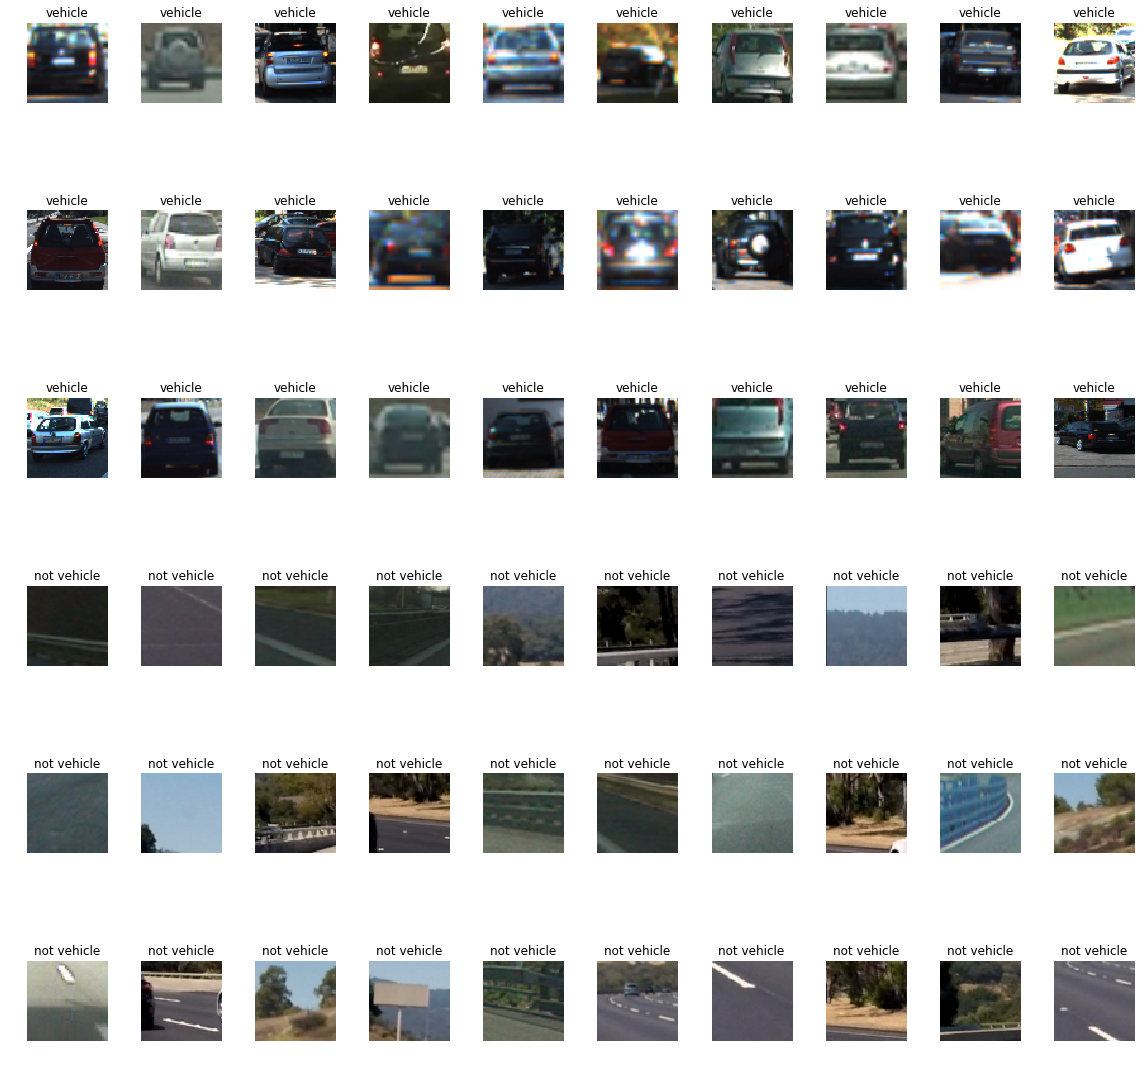

In [3]:
fig, axs = plt.subplots(6, 10, figsize=(16, 16))
axs = axs.ravel()


for i in range(30):
    img = cv2.imread(vehicles[np.random.randint(0,len(vehicles))])
    axs[i].axis('off')
    axs[i].set_title('vehicle')
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for i in range(30,60):
    img = cv2.imread(non_vehicles[np.random.randint(0,len(non_vehicles))])
    axs[i].axis('off')
    axs[i].set_title('not vehicle')
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig.tight_layout()

## 2. Feature Extraction
The following features are extracted from the labeled training set images:
* Perform a Histogram of Oriented Gradients (HOG)
* Perform spatial binning (binned color)
* Perform color histograms

In [4]:
# From Udacity 17.34 lesson_functions.py

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Visualize the HOG feature extraction on a random image

(64, 64, 3)


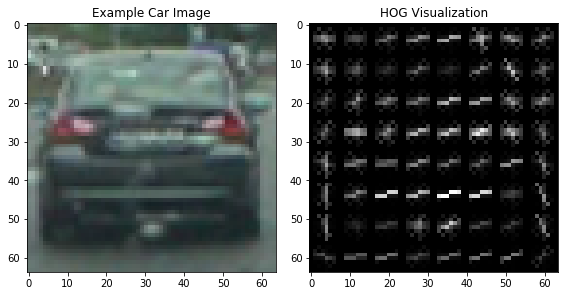

In [5]:
# From Udacity 17.20 get_hog.py
# Generate a random index to look at a car image
ind = np.random.randint(0, len(vehicles))
# Read in the image
image = mpimg.imread(vehicles[ind])
print(image.shape)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.tight_layout()

### Define functions for feature extraction

**get_hog_features** compute histogram of oriented gradient features<br>
**bin_spatial** compute binned color features<br>
**color_hist** compute color histogram features<br>
**extract_features** used for training the classifier, calls one or more of the above functions

In [6]:
# From Udacity 17.22 norm_shuffle.py
# From Udacity 17.34 lesson_functions.py

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Testing Feature Extraction
The code below extracts features and normalizes the data

Vehicles Elapsed: 37.01040983200073
Non-Vehicles Elapsed: 43.693429708480835
cspace	orient	pix_per_cell	cell_per_block	spatial_size	hist_bins	hist_range
YUV 	 9 	 8 		 2 		 (32, 32) 	 32 		 (0, 256)


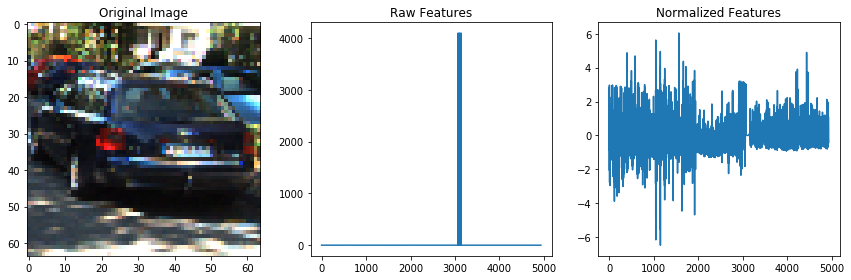

In [7]:
# From Udacity 17.22 norm_shuffle.py
# From Udacity 17.34 

t = time.time()
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0, 256)
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
elapsed = time.time() - t
print('Vehicles Elapsed: %s' % elapsed)

t = time.time()
notcar_features = extract_features(non_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
elapsed = time.time() - t
print('Non-Vehicles Elapsed: %s' % elapsed)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    
    # Since we are combining different features (HOG, binned color, color histogram) we need to normalize
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Plot an example of raw and scaled features from a random image
    car_ind = np.random.randint(0, len(vehicles))
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(vehicles[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')
    
print('cspace\torient\tpix_per_cell\tcell_per_block\tspatial_size\thist_bins\thist_range')
print(color_space, '\t', orient, '\t', pix_per_cell, '\t\t', cell_per_block, '\t\t', spatial_size, '\t', hist_bins, '\t\t', hist_range)

### We now create labels for the binary classification and the training test set

In [8]:
# From Udacity lesson 17.28

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932


## 3. Train a Classifier <a name="train"></a>
Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.  The type of SVM classifier for this project will be a Linear Support Vector Classifier (SVC).

In [9]:
# From Udacity lesson 17.29
# Train a Liner SVC

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 4932
21.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9755
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
0.02998 Seconds to predict 10 labels with SVC


### Save the trained model

In [10]:
# Save the model
joblib.dump(svc, 'svc.pkl') 
joblib.dump(car_features, 'car_features.pkl')
joblib.dump(notcar_features, 'notcar_features.pkl')

# Later you can load back the pickled model (possibly in another Python process) with:
# clf = joblib.load('filename.pkl') 

['notcar_features.pkl']

## 4. Sliding Window Algorithm <a name="sliding_window"></a>
Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.  The type of SVM classifier for this project will be a Linear Support Vector Classifier (SVC).

### Define four new functions:

1. **draw_boxes** utility function called to draw one or more boxes on the image

2. **slide_window** generate a list of windows to search in the source image

3. **single_img_features**	extract the features for a single location (window) within the full image<br>
these features are then passed to the classifier to deterine if there is a match

4. **search_windows**	executes single_img_features to get matches (hot windows)
Note: this also handles the resize of windows to match the classifier

In [11]:
# From Udacity lesson 17.34 search_classify.py

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
#--------------------------------------------------------------------------
#   Purpose:
#           generate a list of windows to search in the source image
#
#   Input:
#           img           source image (to determine for dimensions of search windows)
#           window size   region of interest for search windows
#           window size   how large each window should be (May want this to be dynamic towards the horizon)
#           overlap       how much space between windows<br>
#   Output:
#           window_list   Python list of windows (coordinates/dimensions) that will be used later to run our classifier
#
#--------------------------------------------------------------------------
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Test sliding window algorithm on a single image
Note: We need to make sure the training color space matches the classifier features

# Testing code below on vehicle detection
During testing, it was determined that YCrCb performed better than YUV.
In addition, increasing the orient and hist_bins resulted in better accuracy on the test set.

In [12]:
#------------------------------------------------------------------------
# Define a set of test criteria
#------------------------------------------------------------------------
# HOG tuning parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# Binned Color tuning parameters
spatial_size = (32, 32) # Spatial binning dimensions
# Color Histogram tuning parameters
hist_bins = 64    # Number of histogram bins
hist_range = (0, 256)

# Select which features to extract
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#------------------------------------------------------------------------


# Read in cars and notcars
cars = vehicles
notcars = non_vehicles   


# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 4000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample

Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9144
3.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9969


### Test Sliding Window Algorithm on a Single Full Image

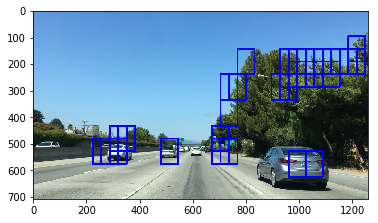

In [13]:
# From Udacity lesson 17.34 search_classify.py

image = mpimg.imread('examples/bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

### Test Sliding Window Algorithm on Multiple Test Images with Region of Interest
We will use multiple test images, some of which were extracted from the project video

In addition, a red box is drawn to indicate the region of interest we search for vehicles

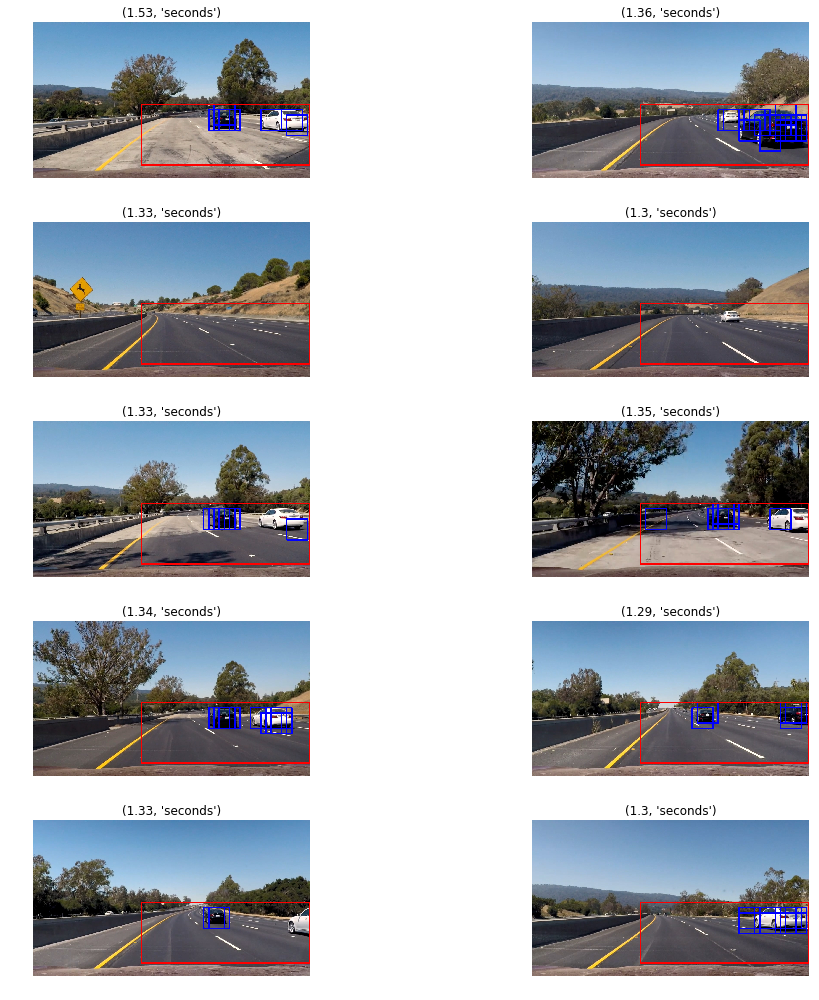

In [14]:
# Define the region of interest for the sliding window
x_start_stop = [500, 1280]
y_start_stop = [380, 660]  # Min and max in y to search in slide_window()

test_images = glob.glob('test_images/test*.jpg')
fig, axs = plt.subplots(5, 2, figsize=(16,14))
#fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()
for i, image in enumerate(test_images):
    image = mpimg.imread(image)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    t=time.time()
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    cv2.rectangle(window_img, (x_start_stop[0], y_start_stop[0]), (x_start_stop[1], y_start_stop[1]), (255,0,0), 6)
 
    t2 = time.time()
    s = round(t2-t, 2), 'seconds'
    axs[i].axis('off')
    axs[i].set_title(s)
    axs[i].imshow(window_img)

    # single plots:
    #plt.figure()
    #plt.title(s)
    #plt.imshow(window_img)
    #plt.show()             # show plot immediately
plt.tight_layout()

### Observations on sliding window algorithm
We observe there is one false positive from the shadow of the tree in the above images, we will deal with this later using sequential frames to improve our detection.
In addition, it takes too long to detect the vehicles (5 seconds).  We need to optimize our feature extraction or searching algorithm for better performance

** We settle on a vertical cropping area of 380 to 660 on the source image**.  This removes above the horizon and the portion of the image that shows the hood of our vehicle.
** In addition, we remove the oncoming traffic that is not on our side of the road **.  This information is distracting to the driver.

### Optimizing Sliding Window Algorithm
We investigate a function that only has to extract the HOG features once: find_cars
This function is modified from the Udacity lesson to provide a list of windows rather than an overlaid image

In [15]:
# From Udacity lesson 17.35

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    xstart = 500
    xstop = img.shape[1]
    
    # CROP OUT LEFT Portion of oncoming traffic
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return on_windows

### Test New Algorithm
We now test the find_cars function to see if it works faster than the previous algorithm

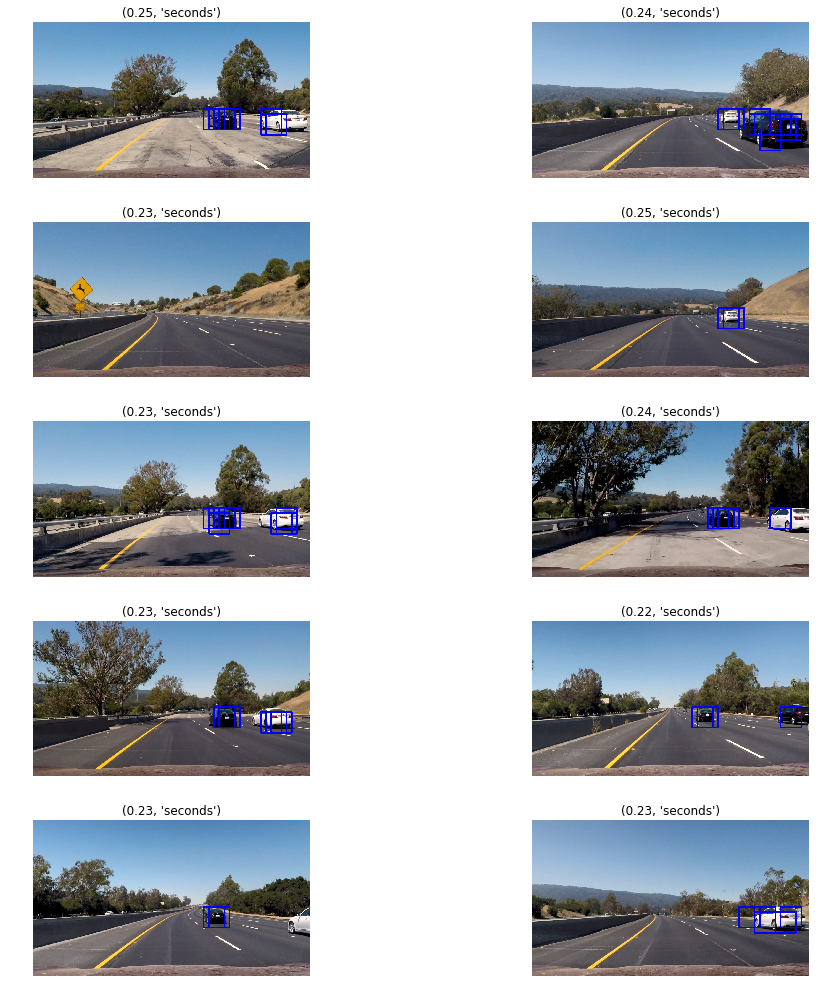

In [16]:
#dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
#svc = dist_pickle["svc"]
#X_scaler = dist_pickle["scaler"]
#orient = dist_pickle["orient"]
#pix_per_cell = dist_pickle["pix_per_cell"]
#cell_per_block = dist_pickle["cell_per_block"]
#spatial_size = dist_pickle["spatial_size"]
#hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('test_images/test1.jpg')
    
ystart = 400
ystop = 656
scale = 1.5
    

# Define the region of interest for the sliding window
# x_start_stop = [None, None]
#y_start_stop = [380, 660]  # Min and max in y to search in slide_window()

test_images = glob.glob('test_images/test*.jpg')
fig, axs = plt.subplots(5, 2, figsize=(16,14))
axs = axs.ravel()
for i, image in enumerate(test_images):
    image = mpimg.imread(image)
    
    # Note: the find_cars function makes a copy of the image and also
    #       accounts for jpg/png differences so this code is no longer used
    # draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    # draw_image = image.astype(np.float32)/255

    t=time.time()
    box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)                   
    out_img = draw_boxes(image, box_list)

    t2 = time.time()
    s = round(t2-t, 2), 'seconds'
    axs[i].axis('off')
    axs[i].set_title(s)
    axs[i].imshow(out_img)

plt.tight_layout()

Indeed, the function is 10x faster, this is a good improvement!

We now need to take into account scaling factors to detect cars near and far away.
This will be done after we implement the heat map.

### Test Scaling and Position
This section tests out various scaling and position windows for the find_cars function
We define the process_frame_test function for this

In [17]:
def test_scale_position(image, scale, ystart, ystop):
    imcopy = np.copy(image)

    rectangles = []
    rectangles.append(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient,
                                    pix_per_cell, cell_per_block, spatial_size, hist_bins))   
    rectangles = [item for sublist in rectangles for item in sublist] 
    draw_img = draw_boxes(imcopy, rectangles, (255,0,0))   

    return draw_img

def test_scale_position_main(scale, ystart, ystop):
    test_images = glob.glob('./test_images/test*.jpg')
    fig, axs = plt.subplots(2, 5, figsize=(16,4))
    axs = axs.ravel()
    print(scale, ystart, ystop)

    for i, im in enumerate(test_images):
        axs[i].imshow(test_scale_position(mpimg.imread(im), scale, ystart, ystop))
        #axs[i].set_title(scale)
        axs[i].axis('off')

    plt.tight_layout()

0.9 400 500


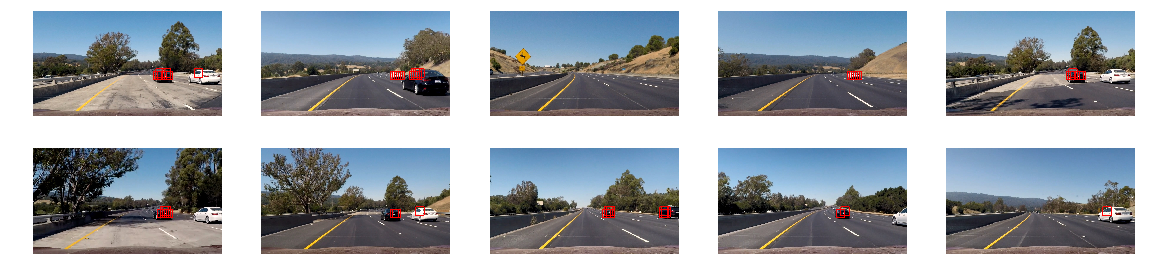

In [18]:
scale = 0.9
ystart = 400
ystop  = 500

test_scale_position_main(scale, ystart, ystop)

1.0 400 600


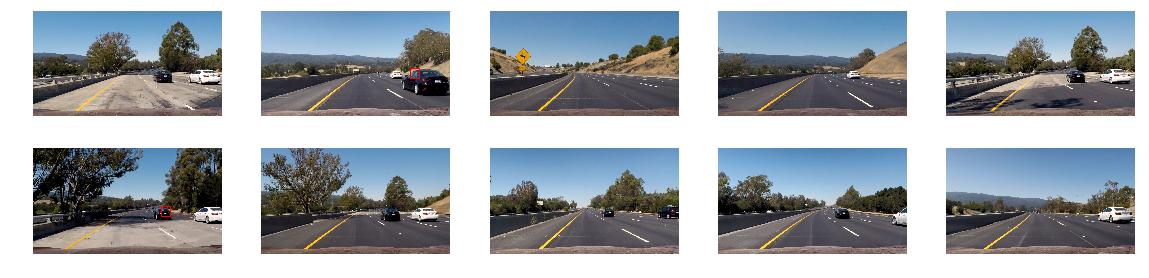

In [19]:
scale = 1.0
ystart = 400
ystop  = 600

test_scale_position_main(scale, ystart, ystop)

1.5 400 656


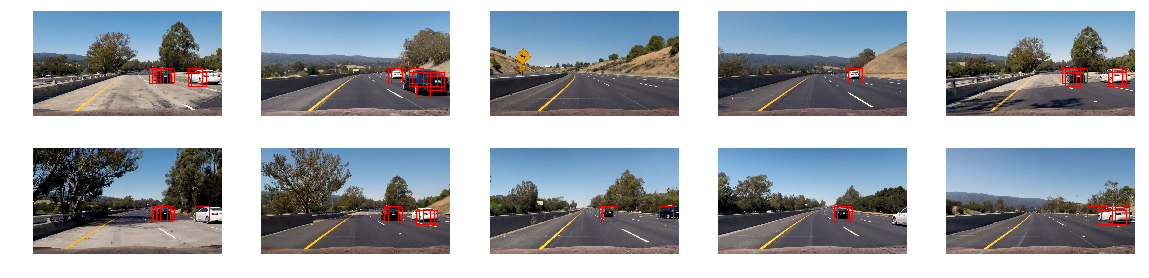

In [20]:
scale = 1.5
ystart = 400
ystop  = 656

test_scale_position_main(scale, ystart, ystop)

2.0 380 600


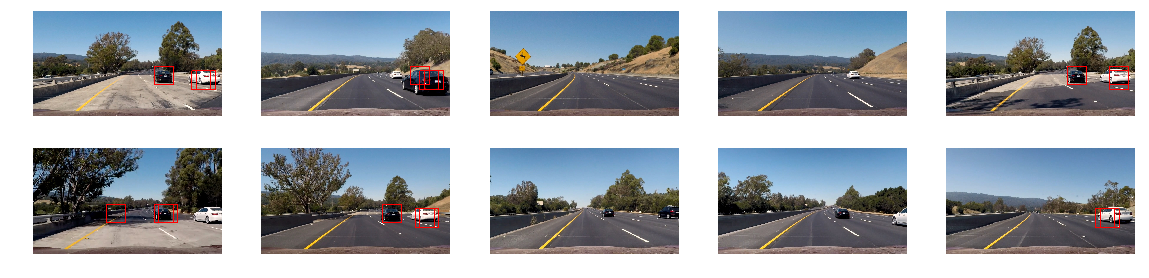

In [21]:
scale = 2.0
ystart = 380
ystop  = 600

test_scale_position_main(scale, ystart, ystop)

2.5 380 660


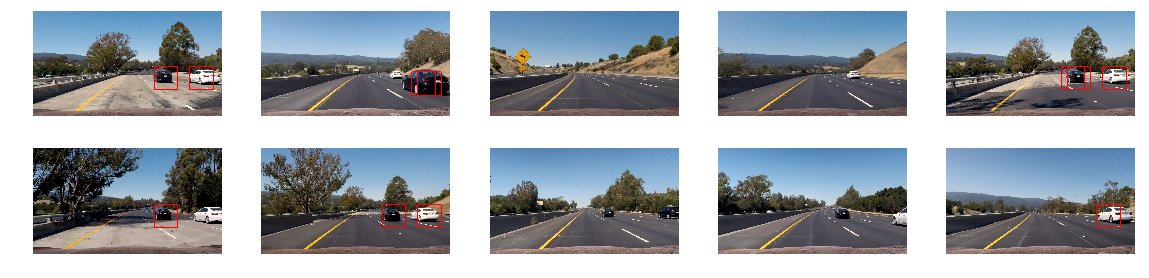

In [22]:
ystart = 380
ystop  = 660
scale = 2.5

test_scale_position_main(scale, ystart, ystop)

3.0 380 660


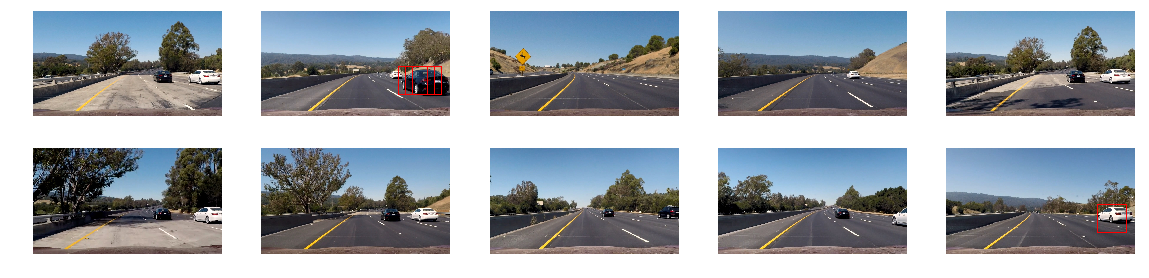

In [23]:
ystart = 380
ystop  = 660
scale = 3.0

test_scale_position_main(scale, ystart, ystop)

### Some observations from the scaling tests:
* Scaling values less than 0.75 cause false positives
* Both the ystart/stop and scale must be changed together, some combinations do not work well

#### The following combinations will be used in the final pipeline:

scale = 0.9
ystart = 400
ystop  = 500

scale = 1.5
ystart = 400
ystop  = 656

scale = 2.0
ystart = 380
ystop  = 600

## 5. Heat Map Algorithm <a name="heat_map"></a>
The concept here is to implement a heat map over multiple frames.  The intensity of the heat map can be used remove false positives along with calculating our vehicle bounding boxes.  This is done with the apply_threshold function.

### Threshold
Once you have a thresholded heat-map, there are many ways you could go about trying to figure out how many cars you have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the label() function from scipy.ndimage.measurements.

In [24]:
# From Udacity lesson 17.36 and 17.37

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

2 cars found


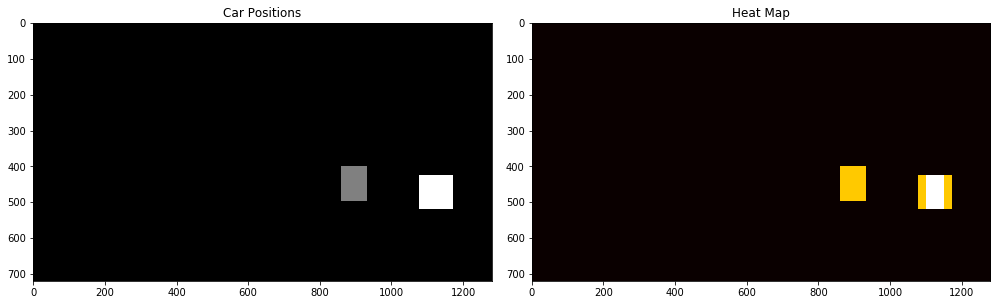

In [40]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
# box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

scale = 1.5
ystart = 400
ystop  = 656


# Read in image similar to one shown above 
image = mpimg.imread('test_images/test6.jpg')
box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)                   

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find heatmap using label function
# From scipy.ndimage.measurements.label
labels = label(heatmap)

fig = plt.figure(figsize=(14,16))
plt.subplot(121)
plt.imshow(labels[0], cmap='gray')
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
print(labels[1], 'cars found')

## 6. Bounding Box Algorithm <a name="calculations"></a>

We define a function **draw_labeled_bboxes** to generate bounding boxes from the heatmaps for each vehicle:

In [41]:
# From Udacity lesson 17.37

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
# Shift boxes left by 10 pixels to account for final pipeline time lag
        bbox = ((np.min(nonzerox)-10, np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Test the Bounding Box Algorithm

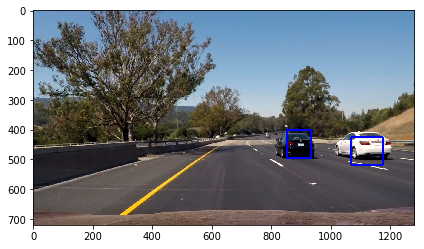

In [42]:
draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(draw_img)
plt.tight_layout()

## 7. Video Pipeline <a name="pipeline"></a>

## 8. Run Pipeline on Project Video <a name="project_video"></a>
 
Note: Some of the basic and testing pipelines are disabled in this project due to a OSError after the first video export:
“OSError: [WinError 6] The handle is invalid” in VideoFileClip function

### Define Cropping Region
We first run a simple test on the video with our overall region of interest bounding box.  This is to determine what we should "crop" out before searching for vehicles.

### Run the basic pipeline below

### A few observations with the basic video above:
* Some frames did not have detections
* The heatmap eliminated false positives well

We now create a class to use history data from previous frames:

In [28]:
# Create a class to store previous frame detections

FRAME_HISTORY_BUFFER = 15

class BoxTracker():
    def __init__(self):
        self.box_history = []
        
    def add_boxes(self, boxes):
        self.box_history.append(boxes)
        if len(self.box_history) > FRAME_HISTORY_BUFFER:
            self.box_history = self.box_history[len(self.box_history)-FRAME_HISTORY_BUFFER:]

In [29]:
def process_frame(image):
    imcopy = np.copy(image)

    boxes = []
    boxes.append(find_cars(image, 400, 500, 0.9, svc, X_scaler, orient,
                                pix_per_cell, cell_per_block, spatial_size, hist_bins))
    boxes.append(find_cars(image, 400, 656, 1.5, svc, X_scaler, orient,
                                pix_per_cell, cell_per_block, spatial_size, hist_bins))
    boxes.append(find_cars(image, 380, 600, 2.0, svc, X_scaler, orient,
                                pix_per_cell, cell_per_block, spatial_size, hist_bins))
    boxes = [item for sublist in boxes for item in sublist] 
    
    if len(boxes) > 0:
        bt.add_boxes(boxes)
        
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for box_list in bt.box_history:
        heat = add_heat(heat, box_list)           # Add heat to each box in box list
        
    heat = apply_threshold(heat, 5)                # Apply threshold to help remove false positives  
    heatmap = np.clip(heat, 0, 255)               # Visualize the heatmap when displaying  
    labels = label(heatmap)                       # Find heatmap using scipy.ndimage.measurements.label
    draw_img = draw_labeled_bboxes(imcopy, labels)   

    return draw_img

In [31]:
bt = BoxTracker()

output_file = 'project_video_final.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(10.,14.)
clip = clip1.fl_image(process_frame)
%time clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_final_dbl.mp4
[MoviePy] Writing video project_video_final_dbl.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [12:01<00:00,  1.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final_dbl.mp4 

Wall time: 12min 2s
